<a href="https://colab.research.google.com/github/matan034/Knee-Bone-Segmentation/blob/main/KneeProject_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Constants


In [ ]:
!pip install scikit-image
!pip install numpy-stl
!pip install trimesh
!pip install pynrrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.6/681.6 kB 16.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os,glob
import matplotlib.pyplot as plt
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pickle
import nibabel as nib
from skimage import measure
from stl import mesh
import shutil
import trimesh
from datetime import datetime
import nrrd
import keras.backend as K
from keras.losses import binary_crossentropy


In [ ]:
IMAGE_HEIGHT =  256
IMAGE_WIDTH = 256
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
BATCH_SIZE_VALIDATION = 1
SEED = 909
drive.mount('/content/drive')
IS_BOUNDARY_PATH = False
LOSS_FUNC_DICE=True
LOSS_FUNC_TRAV=False
USE_IOU = True
TRANSFER_LEARNING = True
CLASSIFIER =False
EXTRA_LAYER = True

if IS_BOUNDARY_PATH:

  data_dir_val_image = '/content/drive/My Drive/KneeProject/validationBoundary/img/' #when creating boundary images go to path validationBoundary regular images in validation
  data_dir_val_mask = '/content/drive/My Drive/KneeProject/validationBoundary/mask/'
else:

   data_dir_val_image = '/content/drive/My Drive/KneeProject/validation/img/' #when creating boundary images go to path validationBoundary regular images in validation
   data_dir_val_mask = '/content/drive/My Drive/KneeProject/validation/mask/'

Mounted at /content/drive


In [ ]:

def dice_coefficient(y_true, y_pred, smooth=1):
    # Flatten the inputs
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)

    # Calculate the intersection and union
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f)

    # Calculate the Dice coefficient
    dice_coef = (2.0 * intersection + smooth) / (union + smooth)

    return dice_coef

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def tversky(y_true, y_pred,smooth = 1):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

# Evaluation metrics: iou
def iou(y_true, y_pred, smooth = 1.):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true) + K.sum(y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac



In [ ]:
def create_segmentation_generator_validation(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255)
    datagen = ImageDataGenerator(**data_gen_args)
    class_mode_selection = 'grayscale'
    if TRANSFER_LEARNING or CLASSIFIER:
      class_mode_selection = 'rgb'
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, color_mode=class_mode_selection,class_mode=None,  batch_size=BATCH_SIZE, seed=SEED) #color_mode='grayscale'
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, color_mode=class_mode_selection,class_mode=None,  batch_size=BATCH_SIZE, seed=SEED) #color_mode='grayscale'
    return zip(img_generator, msk_generator)

In [ ]:
validation_generator = create_segmentation_generator_validation(data_dir_val_image, data_dir_val_mask, BATCH_SIZE_VALIDATION)

Found 1052 images belonging to 1 classes.
Found 1052 images belonging to 1 classes.


# Load model from file
*   provide paths to model json and h5 files.
*   if you need model history provide pkl file as well.


In [ ]:
# Load model architecture from JSON file
with open('/content/drive/MyDrive/KneeProject/Best results/Attention with everything/all_Attention-UNET_(256_256)_epochs:150_learning:0.0001_loss:Tver_batch:64.json', 'r') as json_file:
    loaded_model_json = json_file.read()
    loaded_model = tf.keras.models.model_from_json(loaded_model_json)

# Load weights into loaded model
loaded_model.load_weights('/content/drive/MyDrive/KneeProject/Best results/Attention with everything/all_Attention-UNET_(256_256)_epochs:150_learning:0.0001_loss:Tver_batch:64.h5')

model = loaded_model

#if you dont have a pkl file comment this out
with open('/content/drive/MyDrive/KneeProject/Best results/Attention with everything/all_Attention-UNET_(256_256)_epochs:150_learning:0.0001_loss:Tver_batch:64.pkl', 'rb') as f:
    history = pickle.load(f)


print('Model loaded from disk.')


Model loaded from disk.


# Model results

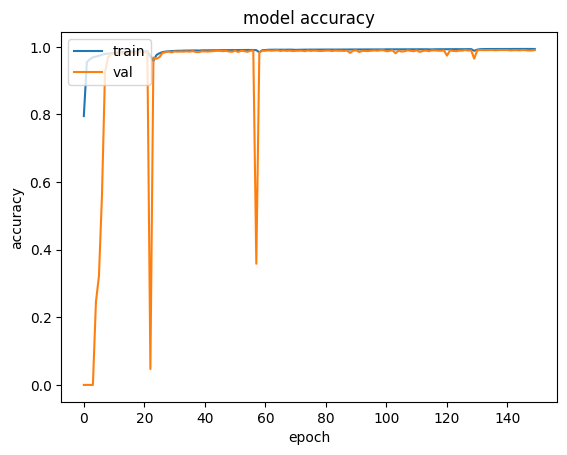

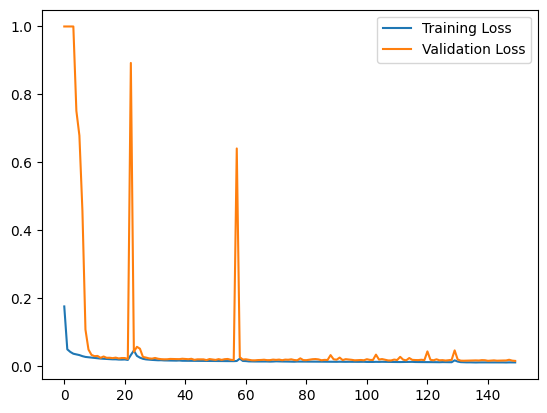

In [ ]:

loss_name=""
if LOSS_FUNC_DICE:
  loss_name="dice_coefficient"
if LOSS_FUNC_TRAV:
  loss_name="tversky"
if USE_IOU:
  loss_name="iou"

plt.plot(history.history[loss_name])
plt.plot(history.history[f'val_{loss_name}'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
def display(display_list):
    plt.figure(figsize=(15,15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

In [ ]:
def show_prediction(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        pred_mask = model.predict(image)[0]  > 0.5
        display([image[0], mask[0], pred_mask])

1/1 [==============================] - 12s 12s/step


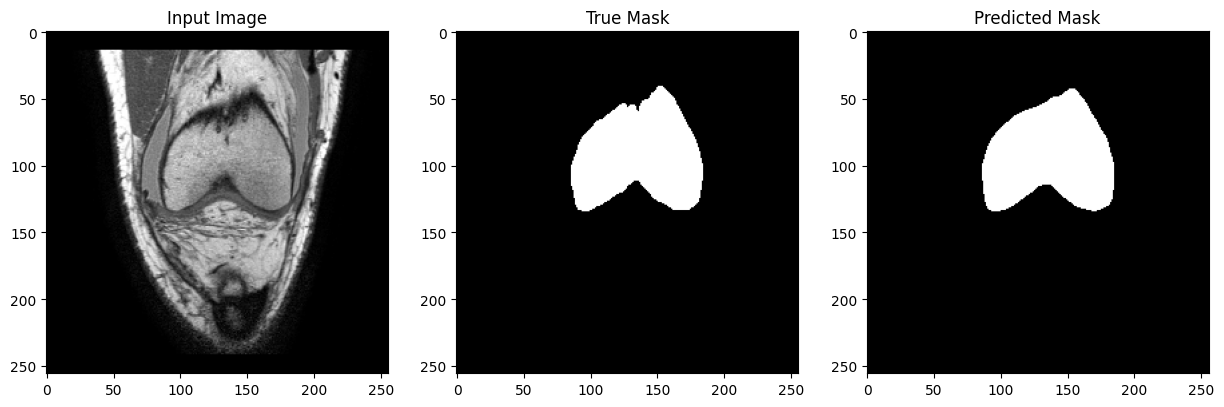

1/1 [==============================] - 0s 43ms/step


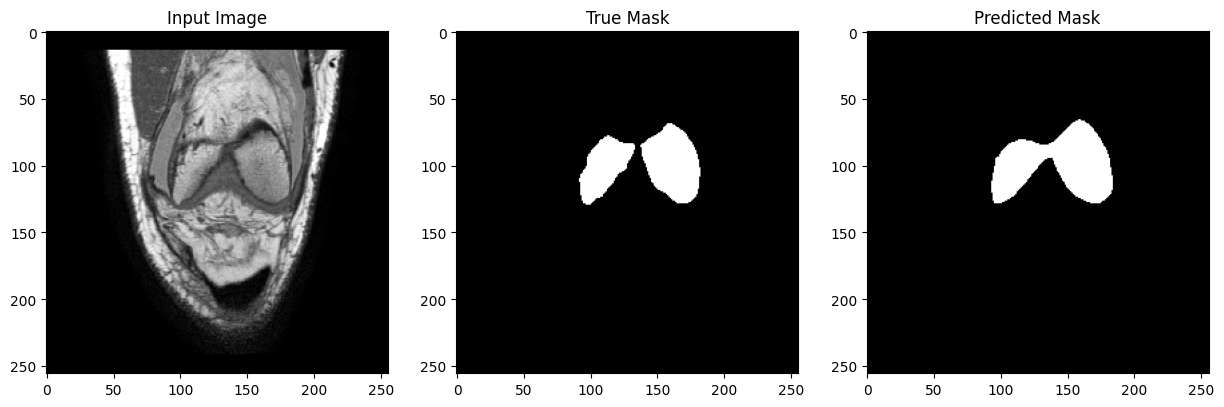

1/1 [==============================] - 0s 27ms/step


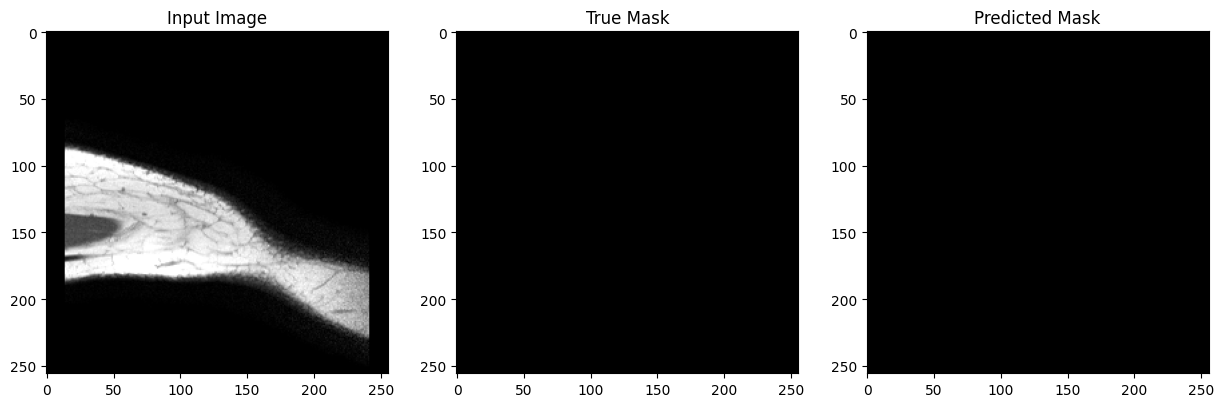

1/1 [==============================] - 0s 29ms/step


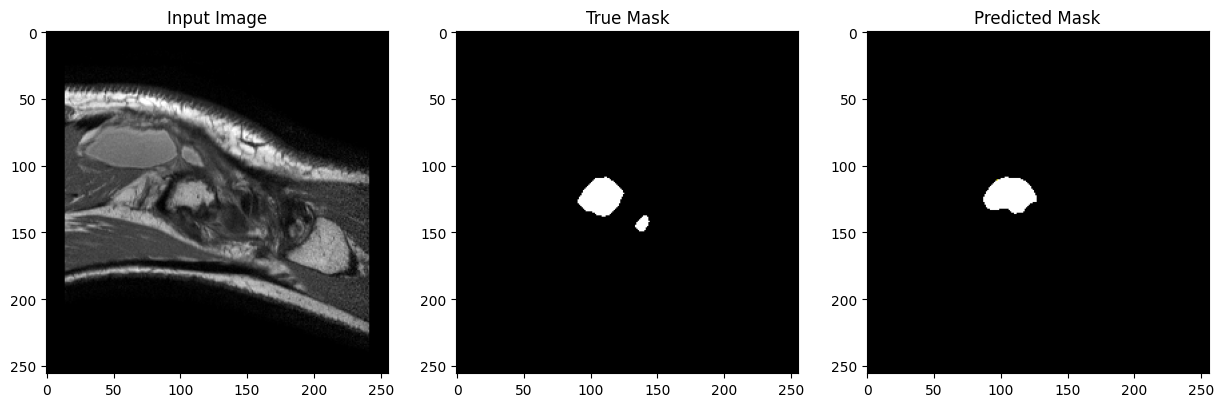

1/1 [==============================] - 0s 27ms/step


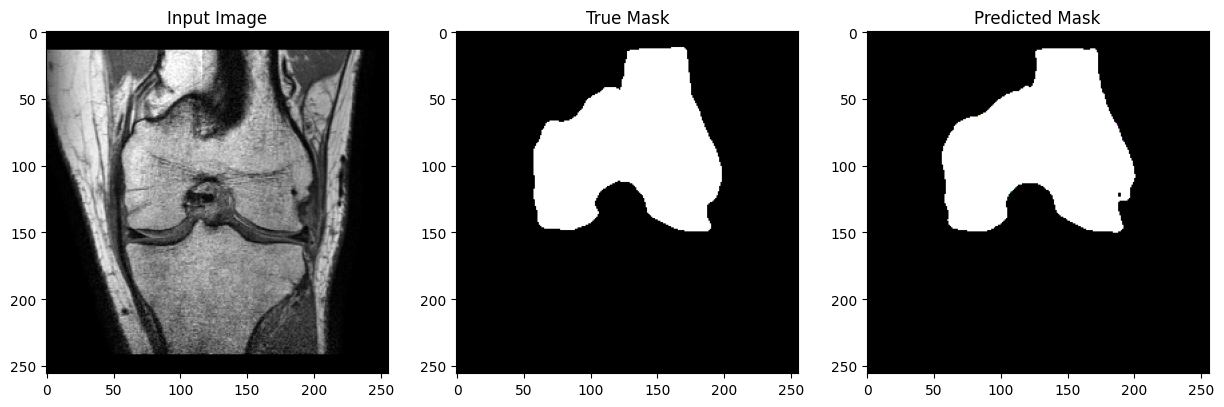

1/1 [==============================] - 0s 26ms/step


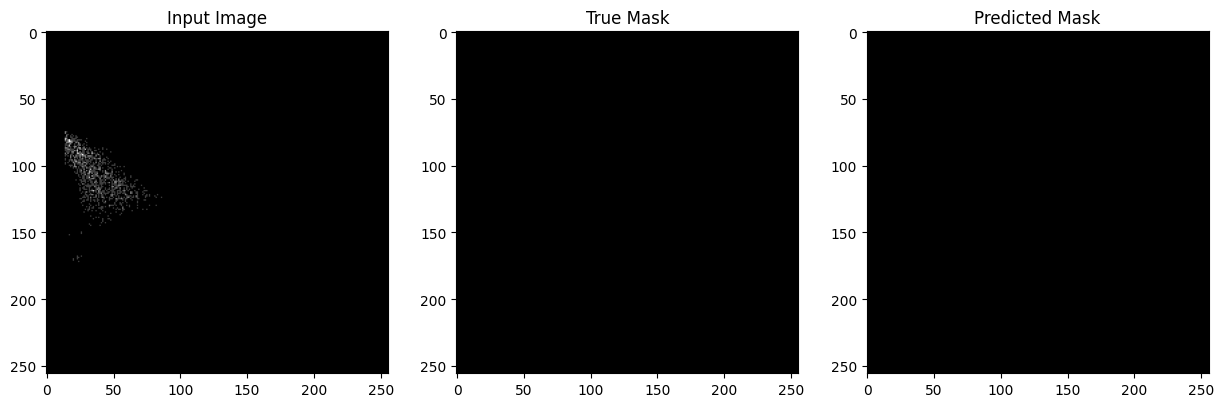

1/1 [==============================] - 0s 30ms/step


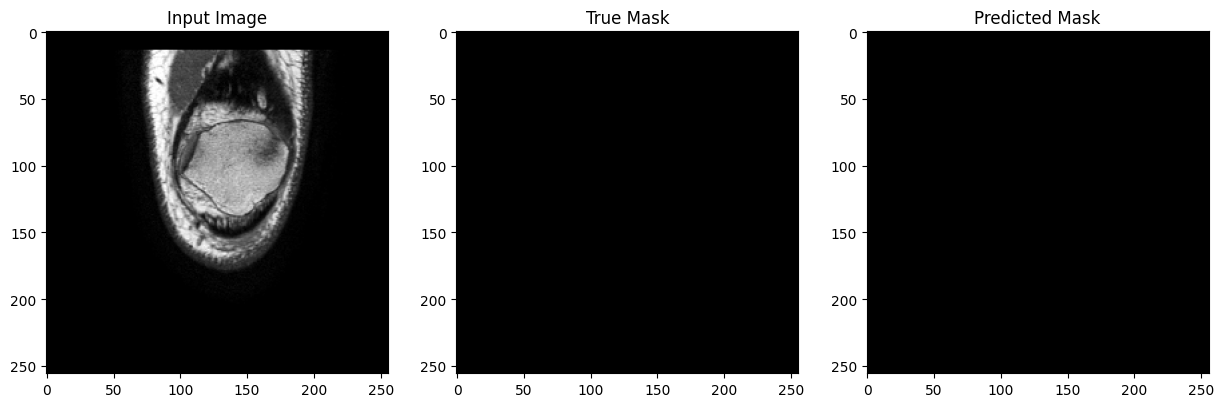

1/1 [==============================] - 0s 39ms/step


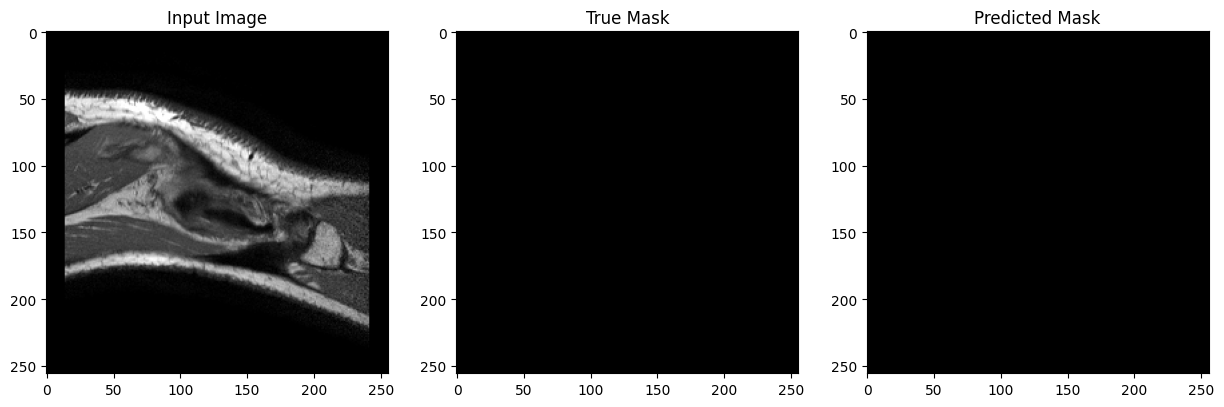

1/1 [==============================] - 0s 45ms/step


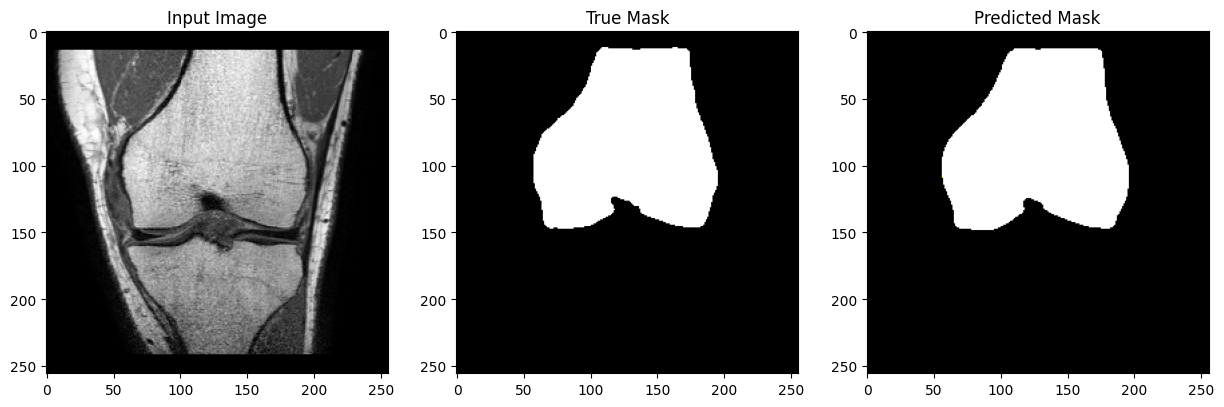

1/1 [==============================] - 0s 30ms/step


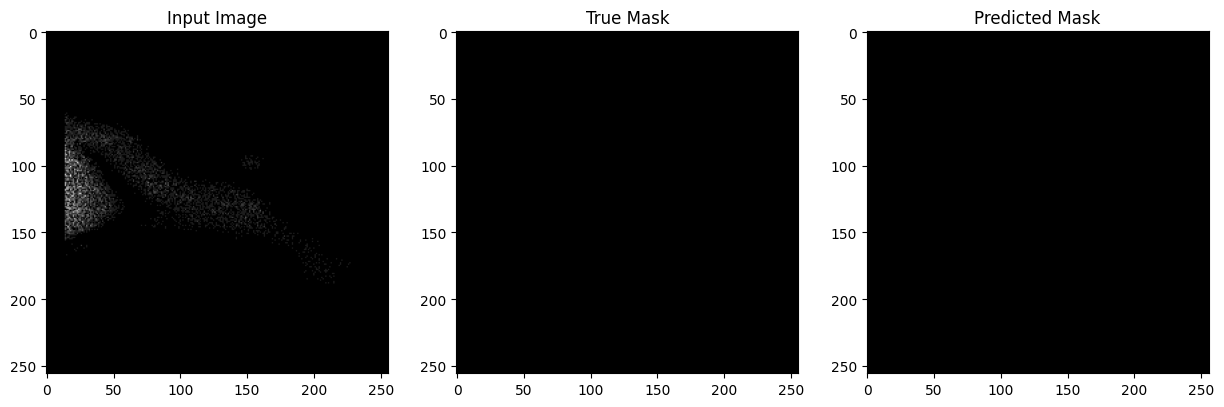

In [ ]:
show_prediction(validation_generator, 10)

# Predict entire volume, create 3d mesh

In [ ]:
VOLUME_SLICE_X=True
VOLUME_SLICE_Y=True
VOLUME_SLICE_Z=True
HOUNSFIELD_MIN = -1000
HOUNSFIELD_MAX = 2000
HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN
def scaleImg(img, height, width):
    return cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_LINEAR)

# Normalize image
def normalizeImageIntensityRange(img):
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE

def predictVolume(inImg, toBin=True):
    (xMax, yMax, zMax) = inImg.shape

    outImgX = np.zeros((xMax, yMax, zMax))
    outImgY = np.zeros((xMax, yMax, zMax))
    outImgZ = np.zeros((xMax, yMax, zMax))

    cnt = 0.0
    if VOLUME_SLICE_X:
        cnt += 1.0
        for i in range(xMax):
            img = inImg[i,:,:]
            img = scaleImg(img, IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            if TRANSFER_LEARNING or CLASSIFIER:
              img = np.repeat(img, 3, axis=3)
            tmp = model.predict(img)[0,:,:,0]
            outImgX[i,:,:] = scaleImg(tmp, yMax, zMax)
    if VOLUME_SLICE_Y:
        cnt += 1.0
        for i in range(yMax):
            img = scaleImg(inImg[:,i,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            if TRANSFER_LEARNING or CLASSIFIER:
              img = np.repeat(img, 3, axis=3)
            tmp = model.predict(img)[0,:,:,0]
            outImgY[:,i,:] = scaleImg(tmp, xMax, zMax)
    if VOLUME_SLICE_Z:
        cnt += 1.0
        for i in range(zMax):
            img = scaleImg(inImg[:,:,i], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            if TRANSFER_LEARNING or CLASSIFIER:
              img = np.repeat(img, 3, axis=3)
            tmp = model.predict(img)[0,:,:,0]
            outImgZ[:,:,i] = scaleImg(tmp, xMax, yMax)

    outImg = (outImgX + outImgY + outImgZ)/cnt
    if(toBin):
        outImg[outImg>0.5] = 1.0
        outImg[outImg<=0.5] = 0.0
    return outImg

In [ ]:
DPath = '/content/drive/My Drive/KneeProject/3D/ZA'
DImageInput = os.path.join(DPath, 'img/')
DMaskInput = os.path.join(DPath, 'mask/')
for index, filename in enumerate(sorted(glob.iglob(DImageInput+'*.nii'))):
    imgTargetNii = nib.load(filename)

imgTarget = normalizeImageIntensityRange(imgTargetNii.get_fdata())
predImg = predictVolume(imgTarget)



1/1 [==============================] - 0s 28ms/step


In [ ]:
vertices, faces, _, _ = measure.marching_cubes(predImg)

knee_mesh=trimesh.Trimesh(vertices,faces)
knee_mesh=trimesh.smoothing.filter_laplacian(knee_mesh,0.5,20)
knee_mesh.export('knee-segmented.stl')


#change directory to save to in drive to your own location and uncomment! without this line file is saved to run time
#shutil.copy('knee-segmented.stl', f'/content/drive/My Drive/KneeProject/3D/Result/knee-segmented-{datetime.now()}.stl')


'/content/drive/My Drive/KneeProject/3D/Result/knee-segmented-2023-06-05 16:13:42.388540.stl'

In [ ]:
flipped_predImg = np.flip(predImg, axis=1)
# Define the NRRD header (use appropriate metadata for your data)
header = {
    'type': 'uint8',
    'dimension': 3,
    'space': 'left-posterior-superior',
    'sizes': predImg.shape,
    'space directions': [[0, 1, 0], [0, 0, 1], [1, 0, 0]],
    'space origin': [0, 0, 0],
    'encoding': 'gzip',
    'endian': 'little'
}

# Save the 3D NumPy array as an NRRD file
nrrd.write('segmentation.seg.nrrd', flipped_predImg, header)
#change directory to save to in drive to your own location and uncomment! without this line file is saved to run time
#shutil.copy('segmentation.seg.nrrd', f'/content/drive/My Drive/KneeProject/3D/Result/segmentation{datetime.now()}.seg.nrrd')

'/content/drive/My Drive/KneeProject/3D/Result/segmentation2023-06-05 16:13:51.940246.seg.nrrd'